# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v0-4a_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v0-4a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_404792fda5c66b95903adafd5a5f5d10...  deutch
1  train/de\de_m_4d099776261f2267d3148a7e7e766d14...  deutch
2  train/de\de_f_0809fd0642232f8c85b0b3d545dc2b5a...  deutch
3  train/de\de_m_d22535879801cc9c4452d9ed9de5bf61...  deutch
4  train/de\de_f_d94712992f41e3d8d21f22274b3d8fd9...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
3210  train/es\es_m_b53274d3ef7996a22d6ec929c1869804...     spanish   
1092  train/en\en_m_1e512792ebab2bd93b7aacac3d521390...     english   
2241  train/pt\pt_m_4453f52afbf500460847b1284d791608...  portuguese   
3203  train/es\es_f_1d27c6d589eeff17973ffd0b7a77a70a...     spanish   
2909  train/es\es_f_bac9be13a058d1c859ed5d2e3a0dc27b...     spanish   
183   train/de\de_f_8e8ed685b0cf9f5bbd13a04629ee64c5...      deutch   
1141  train/en\en_f_17211c49a9b2967b57cffaccf0d5b565...     english   
780   train/en\en_m_81995ee8a5e990193b7858ec4b158e48...     english   
1149  train/en\en_m_1e512792ebab2bd93b7aacac3d521390...     english   
2060  train/pt\pt_m_6c4359035a8b03a516a43880169b4104...  portuguese   
1486  train/fr\fr_m_97ed519900a5692ea56affd2f2d39e56...      french   
500   train/de\de_f_6cc5c71681c0abc094a869e03b357384...      deutch   
2016  train/pt\pt_m_05e97410cde8c060ea43e4daa765781a...  portuguese   
1151  train/en\en_f_b6f3c74f569edd37b4bebd5b0c030497...     english   
123   train/de\de_m_502293f229751563d1768dd2367a6b29...      deutch   
970   train/en\en_m_29119ce8a7ecbf970f9a0728087c8ac3...     english   
2912  train/es\es_m_406bb0dc71a22051d900bc55cdfad59e...     spanish   
2977  train/es\es_f_bf4285930fa46f2052e5bdbc37a8a4df...     spanish   
2198  train/pt\pt_f_52518b4afe4fd19e5f27b5b8de0a409f...  portuguese   
258   train/de\de_m_4d099776261f2267d3148a7e7e766d14...      deutch   
1759  train/fr\fr_m_2a24b6cd1e8b31c8aacece1737ca8a57...      french   
1800  train/fr\fr_m_b8307ff2e13a8c1aa7e5864fa40dca2b...      french   
1119  train/en\en_f_7701e10392ce7bcfba6d2fcca56fb8d9...     english   
2270  train/pt\pt_f_6d7fea289dedf4f37aaf6b5bbba32a8c...  portuguese   
1013  train/en\en_f_10134f409d9b7b0b95fed6e025febcad...     english   
3029  train/es\es_m_4d7e5bf6deb997d71eb46ae46043c3db...     spanish   
935   train/en\en_f_17211c49a9b2967b57cffaccf0d5b565...     english   
2722  train/es\es_m_768526f634547e2b45fd84556ecd70f6...     spanish   
2318  train/pt\pt_f_81c8739c4dcdb663ab6e3bf37b1be540...  portuguese   
559   train/de\de_m_8ea3514af1c01478fbcd004b026fea71...      deutch   
2549  train/pt\pt_f_7557300bd1379338d25b120fe22749d9...  portuguese   
2310  train/pt\pt_m_bcb9dcb5f7a45fe868a6716d1c140d4e...  portuguese   
490   train/de\de_m_8ea3514af1c01478fbcd004b026fea71...      deutch   
1077  train/en\en_m_1e512792ebab2bd93b7aacac3d521390...     english   
1554  train/fr\fr_m_3c5d7ff8edca428bdab8f03dee5f9056...      french   
2627  train/es\es_m_f16e9da2ba7126292cb4e46ce16995bc...     spanish   
345   train/de\de_f_9bd3b58fe6f75dc40e85021914b4b06a...      deutch   
2738  train/es\es_f_2b24d20198e528ae803107e9beadacc9...     spanish   
1522  train/fr\fr_m_5947212db4c738c8503ee5ec8a72d37b...      french   
1125  train/en\en_m_597da7d934dbb4df3da45acf11536350...     english   

      sample_rate                                        time_series  nframes  \
3210        16000  [5, 7, 4, 4, 4, 4, 2, 1, 1, 1, 1, 0, 1, 0, 1, ...    80000   
1092        16000  [-745, -92, -405, 13, 407, 15, 110, 462, 695, ...    80000   
2241        16000  [123, 55, 69, 52, 64, 69, 101, 129, 40, 49, 40...    80000   
3203        16000  [1353, 1464, 1677, 1551, 859, 492, -37, -914, ...    80000   
2909        16000  [-2, 1, -9, -7, -2, 5, 3, 10, 6, 6, 5, 1, -4, ...    80000   
183         16000  [1333, 1510, 2382, 3685, 5200, 6771, 8094, 920...    80000   
1141        16000  [4027, 3287, 2936, 3036, 2325, 1597, 1744, 190...    80000   
780         16000  [-10814, -17874, -21938, -22366, -20127, -1504...    80000   
1149        16000  [-54, 38, 69, -69, -127, 214, 147, 24, 4, 242,...    80000   
2060        16000  [-2220, 528, 1347, -3599, 2892, -133, -2949, 1...    80000   
1486        16000  [-5646, -5795, -5295, -5068, -5243, -5230, -50...    80000   
500         16000  [5183, 4252, 3574, 3410, 2020, 904, 134, -1516...    80000   
2016        16000  [0, 2, 1, 0, -3, -6, -3, -2, 1, -3, 1, 3, 0, 0...    80000   


In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_404792fda5c66b95903adafd5a5f5d10...  deutch   
1  train/de\de_m_4d099776261f2267d3148a7e7e766d14...  deutch   
2  train/de\de_f_0809fd0642232f8c85b0b3d545dc2b5a...  deutch   
3  train/de\de_m_d22535879801cc9c4452d9ed9de5bf61...  deutch   
4  train/de\de_f_d94712992f41e3d8d21f22274b3d8fd9...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_404792fda5c66b95903           None           None      None     None   
1  de_m_4d099776261f2267d31           None           None      None     None   
2  de_f_0809fd0642232f8c85b           None           None      None     None   
3  de_m_d22535879801cc9c445           None           None      None     None   
4  de_f_d94712992f41e3d8d21           None           None      None     None   

   augmented_data  
0           False  
1           False  
2           False  
3           False  
4           False

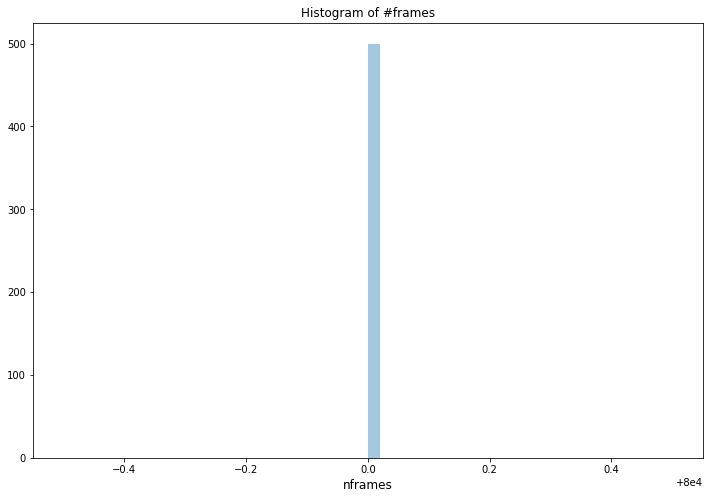

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

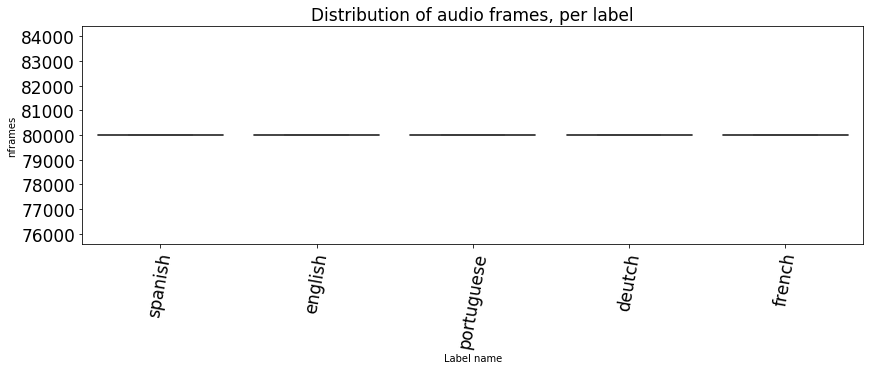

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0    train/de\de_f_404792fda5c66b95903adafd5a5f5d10...  deutch   
425  train/de\de_m_8ea3514af1c01478fbcd004b026fea71...  deutch   
426  train/de\de_m_3aa01c55ba7ca85cad2977c848eb826f...  deutch   
427  train/de\de_m_ab485e46a6cce6d4b0f4ab48c08f9a4d...  deutch   
428  train/de\de_m_bcc15ea7f0b2b21804393bca63f6c2c2...  deutch   

                    file_name speed_changing pitch_changing noise_add  \
0    de_f_404792fda5c66b95903           None           None      None   
425  de_m_8ea3514af1c01478fbc           None           None      None   
426  de_m_3aa01c55ba7ca85cad2           None           None      None   
427  de_m_ab485e46a6cce6d4b0f           None           None      None   
428  de_m_bcc15ea7f0b2b218043           None           None      None   

    low_pass  augmented_data  
0       None           False  
425     None           False  
426     None           False  
427     None           False  
428     None           False

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

643

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


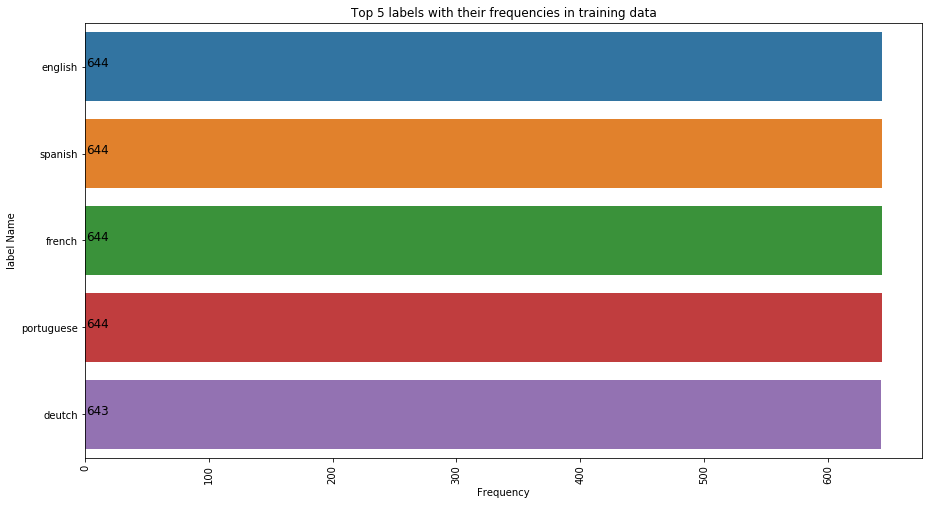

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                29
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809fd0642232f8c85b     23
       de_f_1996a0f045b3301946a     23
       de_f_26ddc4e756f61233d74     23
       de_f_2825fa225d6ca4800f0     23
       de_f_404792fda5c66b95903     23

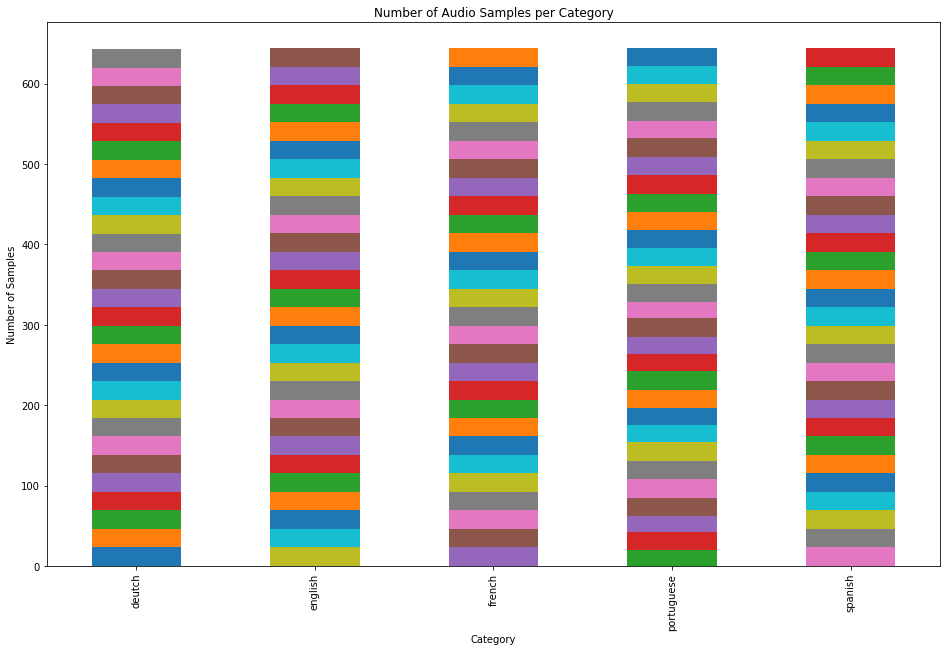

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f         322
           m         321
english    f         322
           m         322
french     f         322
           m         322
portuguese f         285
           m         359
spanish    f         322
           m         322

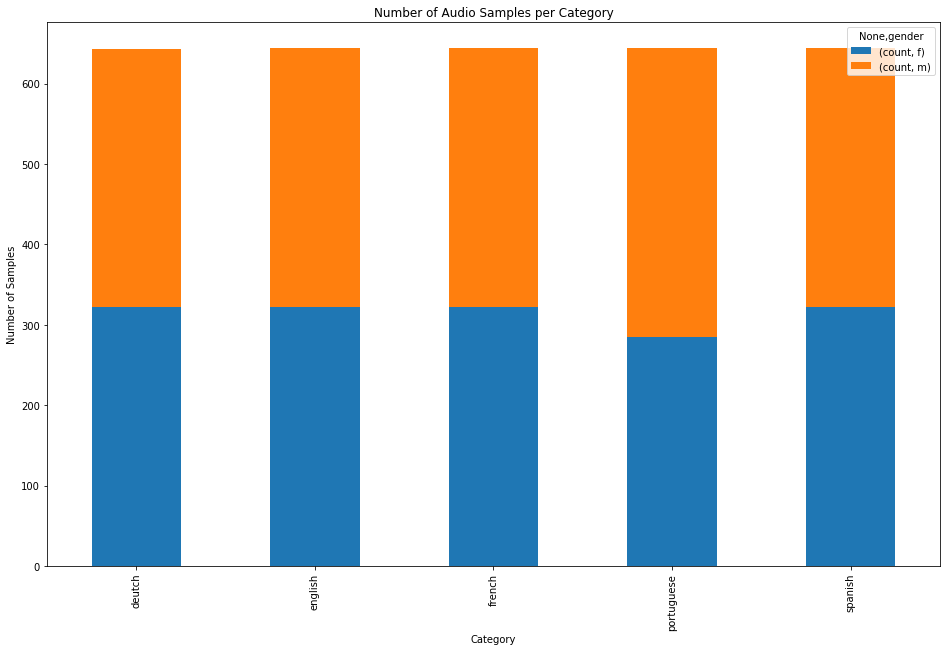

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     False             643
english    False             644
french     False             644
portuguese False             644
spanish    False             644

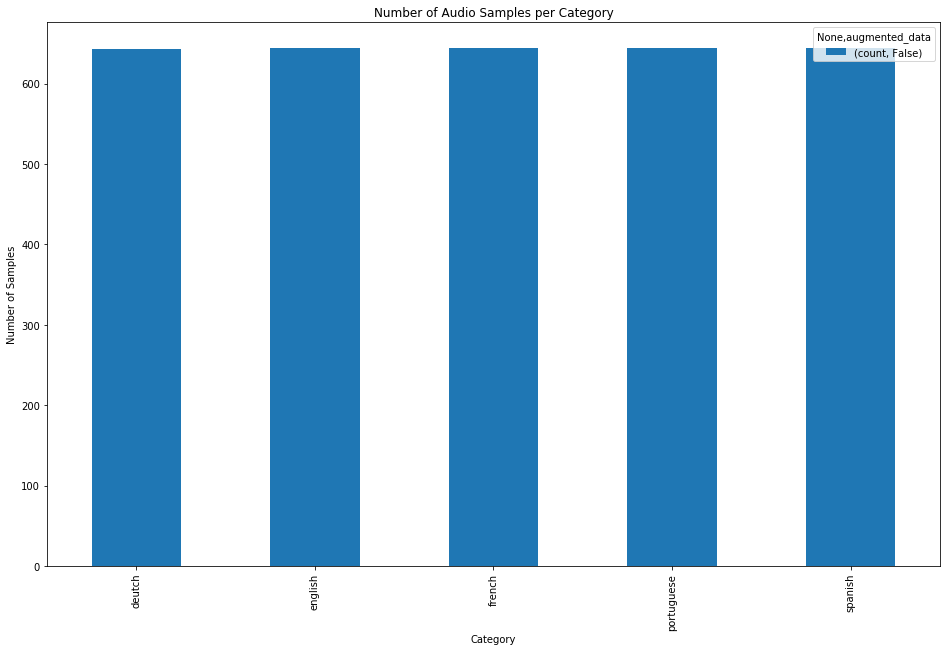

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
deutch     False             643               0               0          0   
english    False             644               0               0          0   
french     False             644               0               0          0   
portuguese False             644               0               0          0   
spanish    False             644               0               0          0   

                           low_pass  
label      augmented_data            
deutch     False                  0  
english    False                  0  
french     False                  0  
portuguese False                  0  
spanish    False                  0

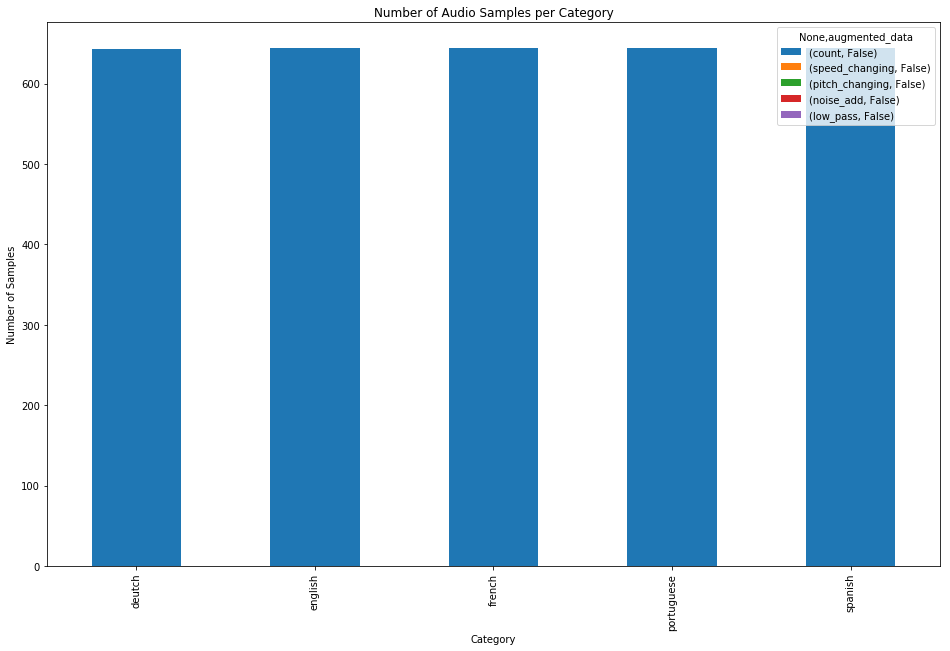

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

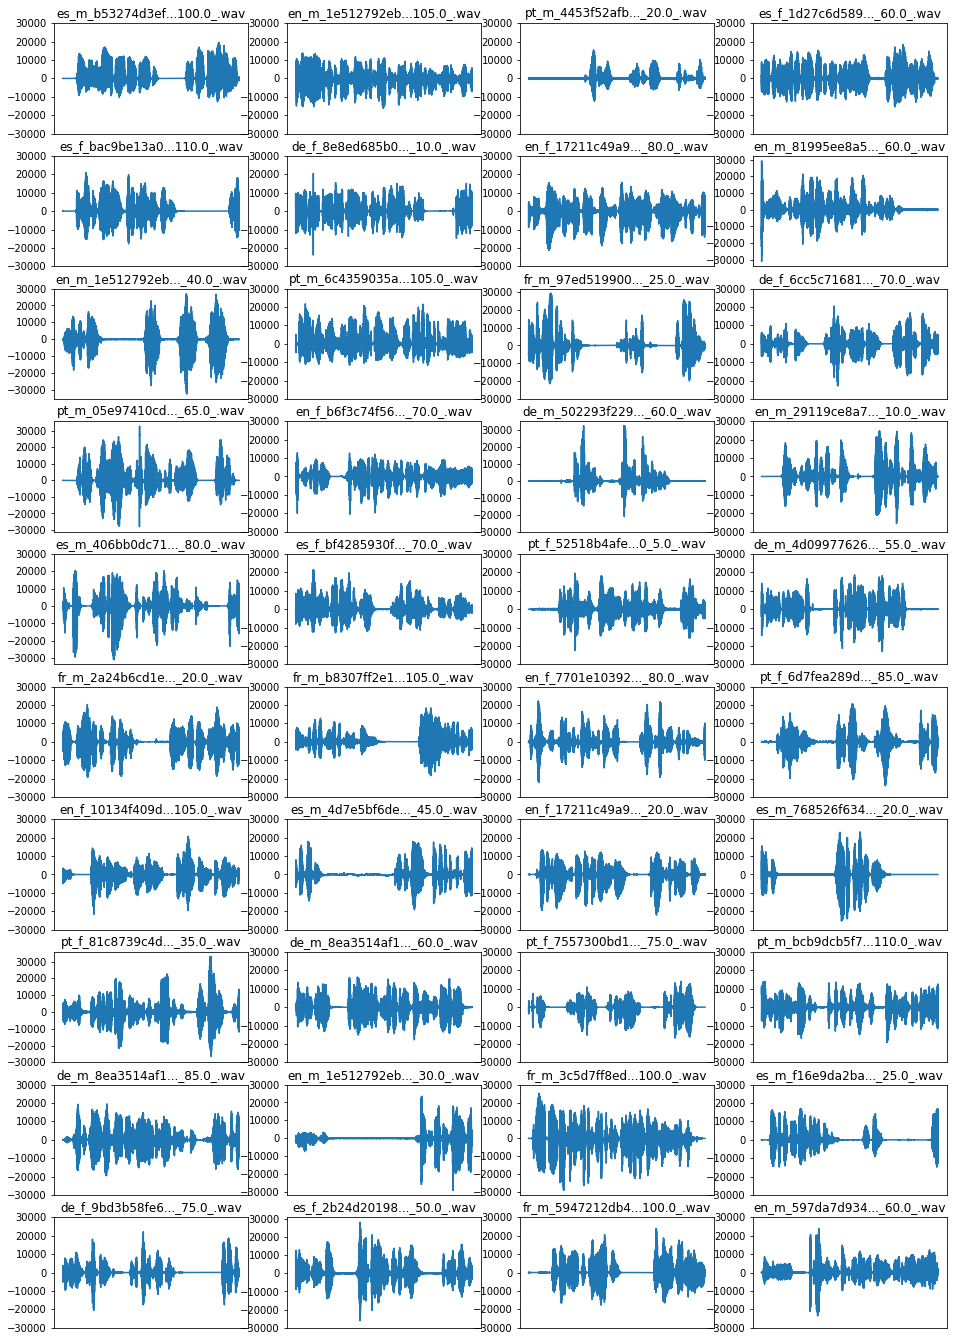

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

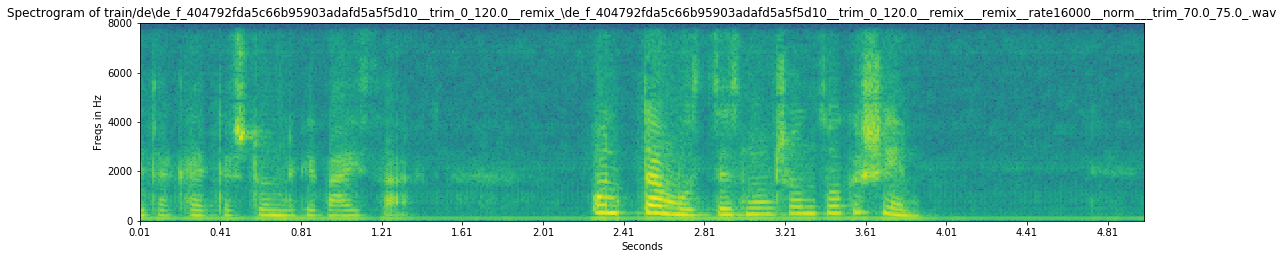

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (3219, 9)


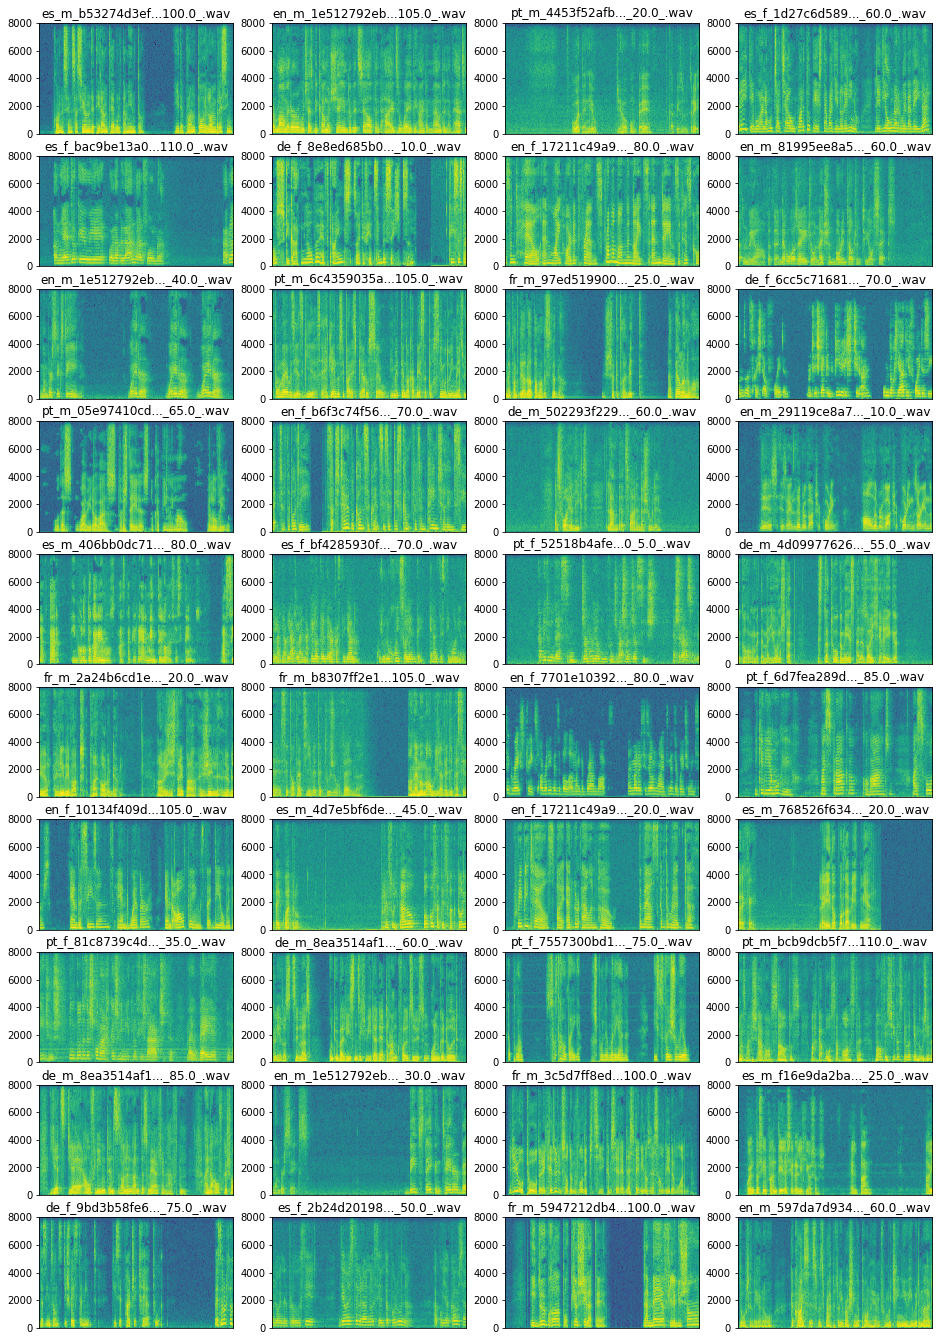

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

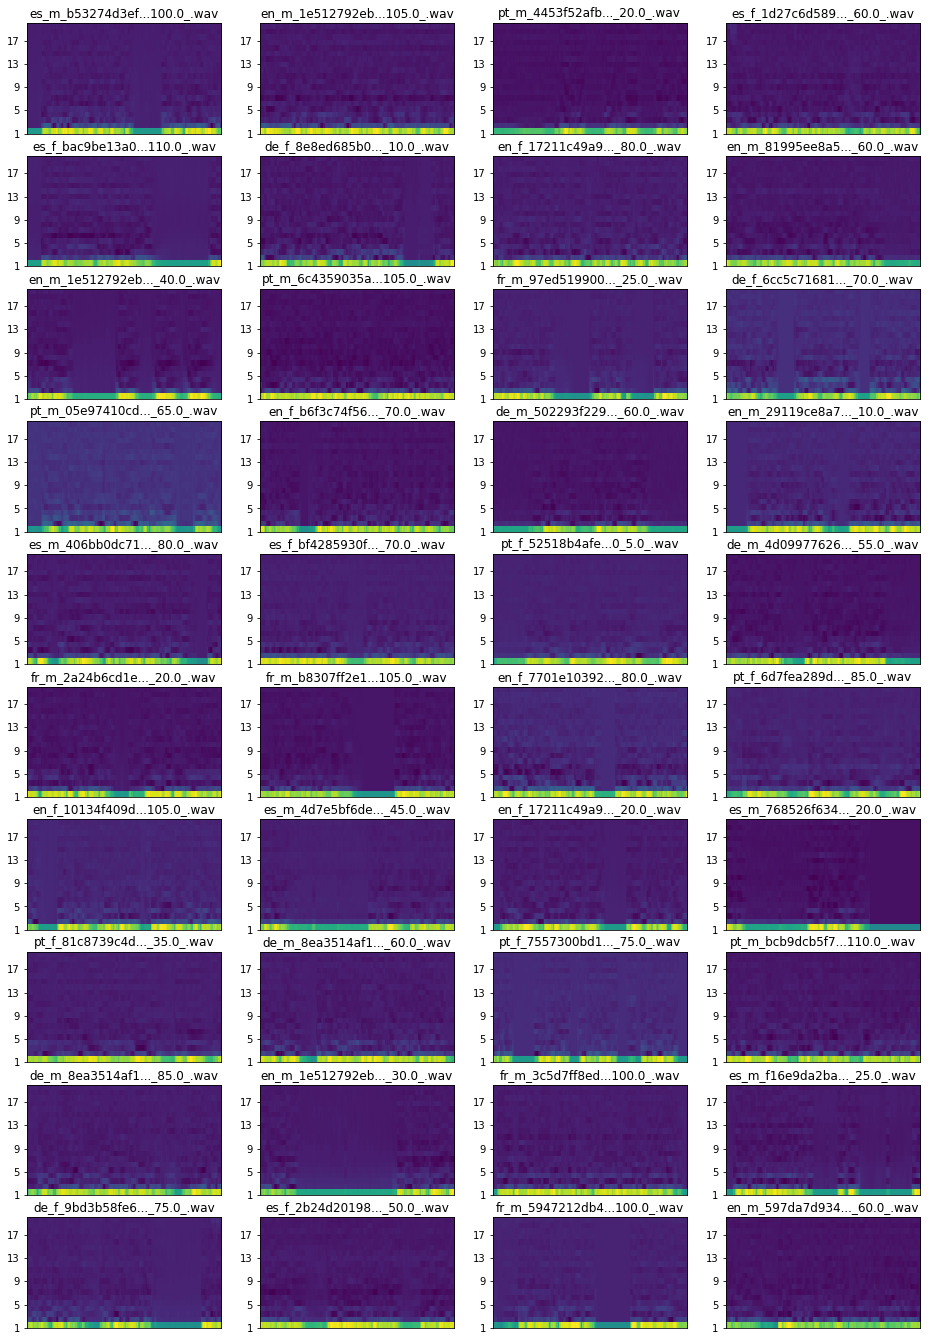

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

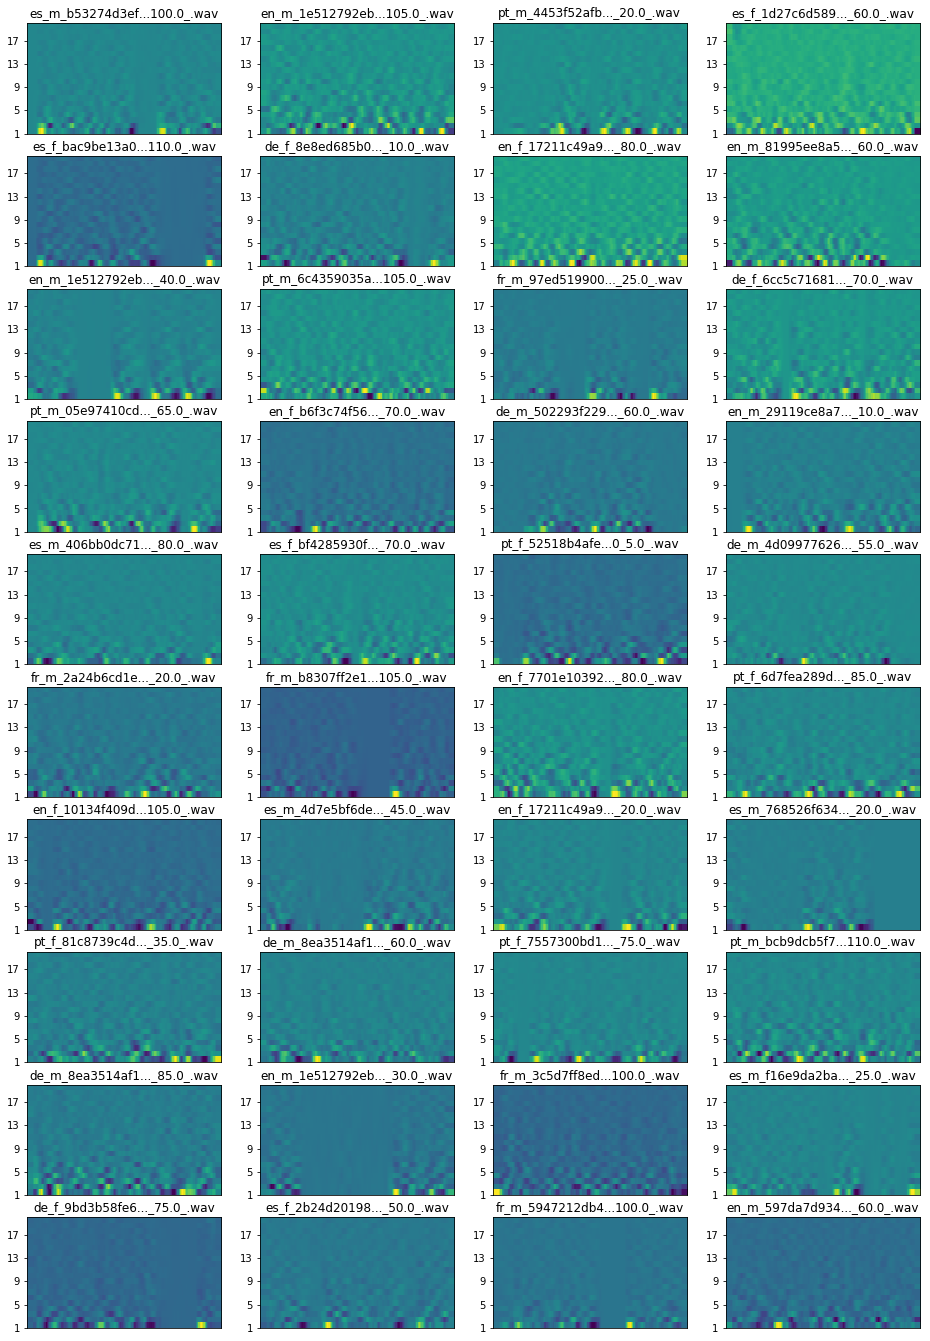

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

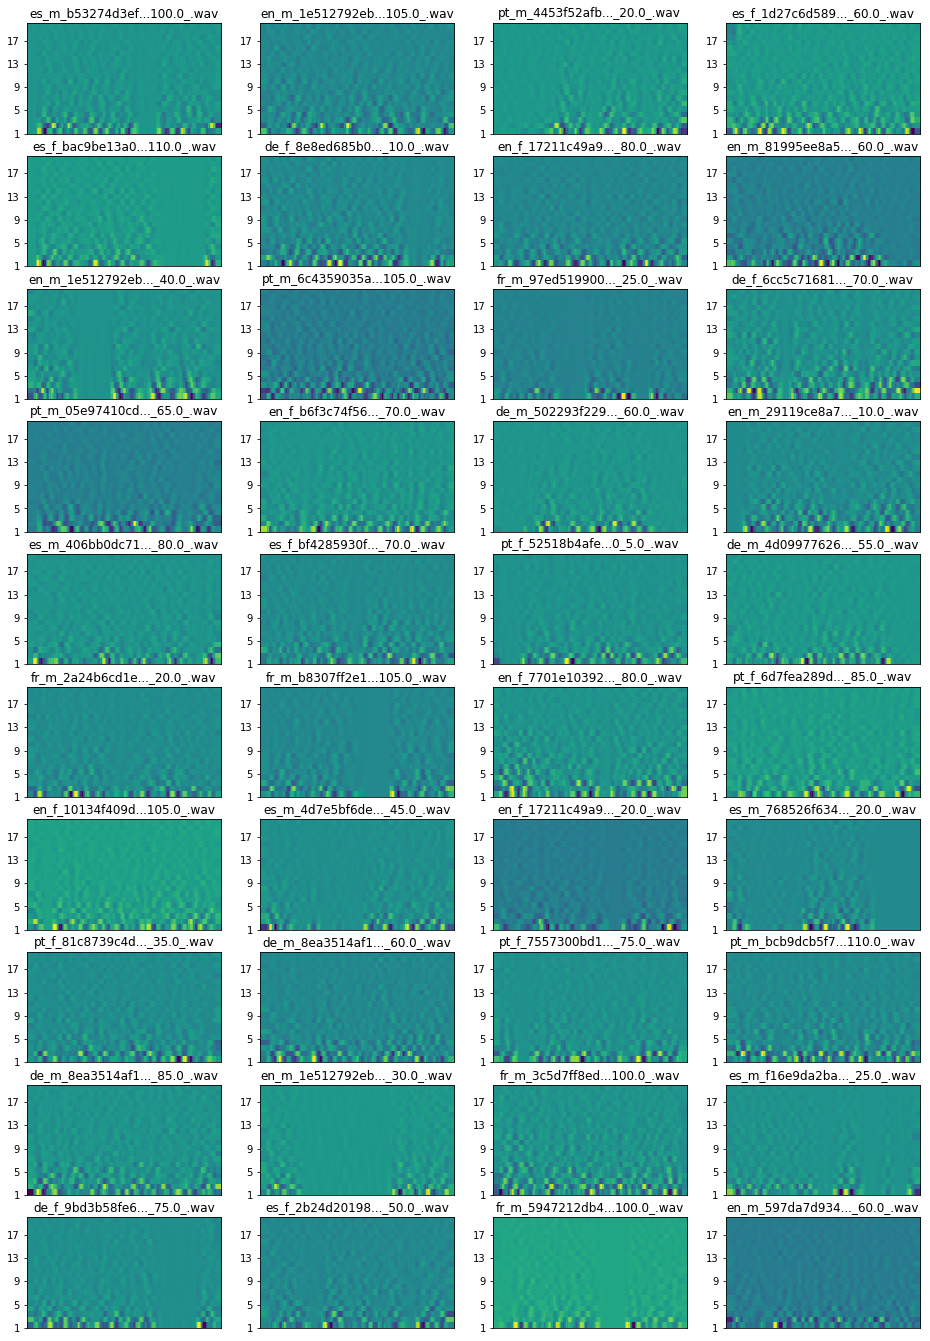

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

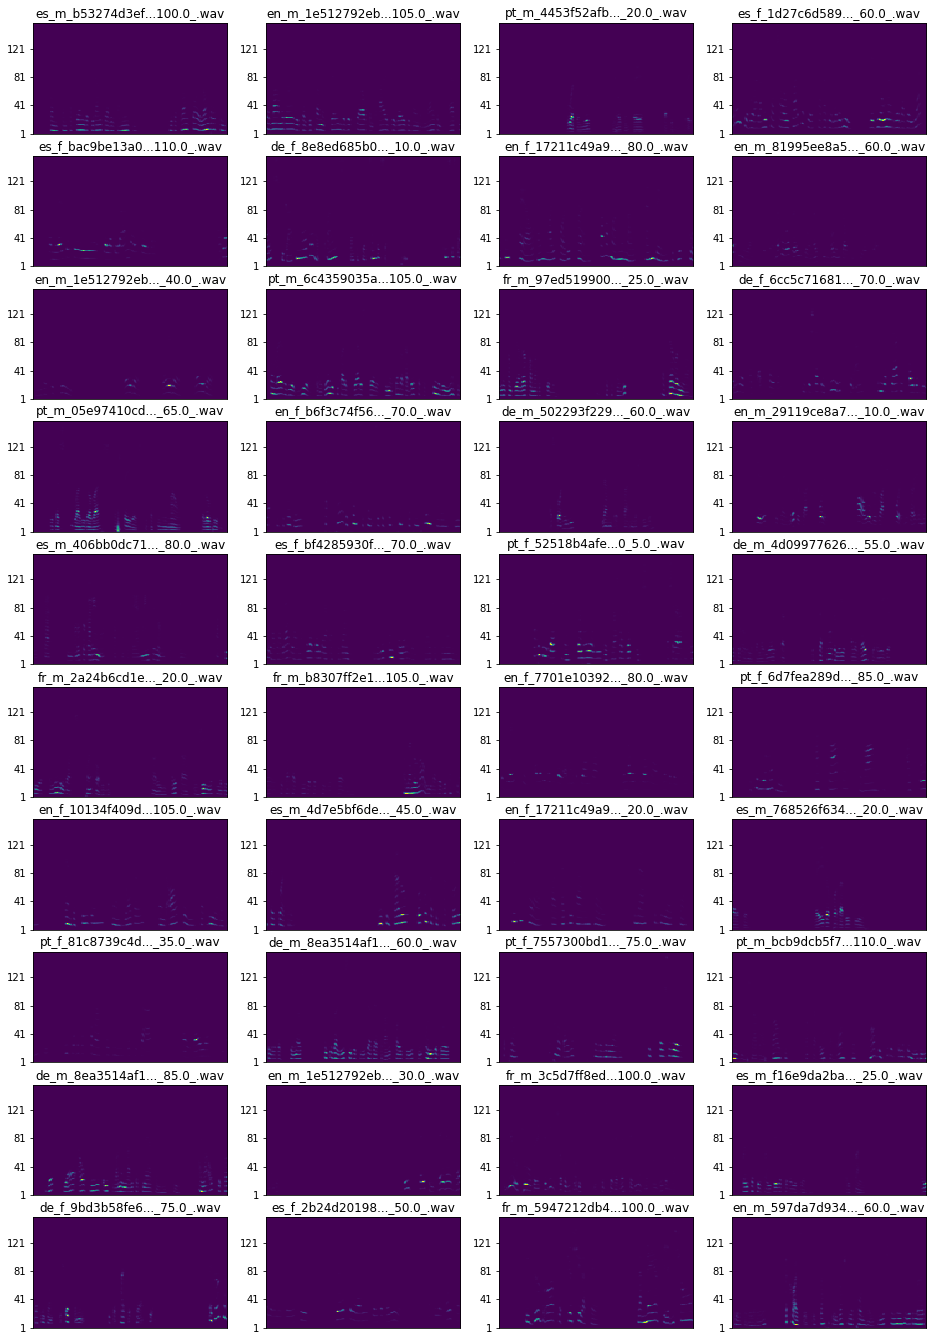

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  